In [1]:
import xarray as xr
import torch
from hython.utils import write_to_zarr
import matplotlib.pyplot as plt
from pathlib import Path
import xbatcher
from xbatcher.loaders.torch import MapDataset
from numcodecs import Blosc

In [2]:
from torchvision.datasets import MovingMNIST

In [3]:
from torch.utils.data import Dataset, DataLoader

In [4]:
from torchvision.transforms import Normalize, ToTensor

In [5]:
wd = Path("/mnt/CEPH_PROJECTS/InterTwin/Wflow/models/adg1km_eobs")

In [6]:
params = xr.open_dataset(wd / "staticmaps.nc")#.chunk("auto")
ds = xr.open_dataset(wd / "forcings.nc")#.chunk("auto") # C T W H => N T C H W
out = xr.open_dataset(wd / "run_default/output.nc").sel(layer=1).isel(lat=slice(None, None, -1))#.chunk("auto") # C T W H => N T C H W

In [85]:
out = out[["vwc", "actevap"]]

In [ ]:
params = params.drop_dims("time").sel(layer=1)[[ 'thetaS', 'thetaR', 'RootingDepth', 'Swood','KsatVer', "Sl"] ]

In [8]:
import numpy as np
params = params.where(~np.isnan(params), 0)
ds = ds.where(~np.isnan(ds), 0)
out = out.where(~np.isnan(out), 0)

In [9]:
try:
    ds = ds.rename({"latitude":"lat", "longitude":"lon"})
    params = params.rename({"latitude":"lat", "longitude":"lon"})
except:
    pass

In [10]:
# compressor = Blosc(cname='zl4', clevel=9, shuffle=Blosc.BITSHUFFLE)

# ss = params.drop_dims("time")[[ 'thetaS', 'thetaR', 'RootingDepth', 'Swood','KsatVer', "Sl"]].expand_dims({"time": ds.time}).chunk({"time":500, "latitude":50, "longitude":50})

# ss.to_zarr(wd / "test.zarr",storage_options={"compressor":compressor})

# ss = xr.open_dataset( wd / "test.zarr", engine = "zarr")

# time, lat, lon = 365, 16, 16 

## Xbatcher

In [11]:
# bgen_x = xbatcher.BatchGenerator(
#     ds = ds, 
#     input_dims = {
#         "time": time,  # time points in each sample (sequence length) 
#         "latitude": lat,
#         "longitude": lon ,
#     },
#     batch_dims = {
#         #"time": 500, # time points in each batch
#         "latitude":16,
#         "longitude":16 
#     },
#     concat_input_dims=True, #True, # 
#     input_overlap={"time":350}
# )

# len(bgen_x), bgen_x[0].to_array().shape

# bgen_x[20].temp[0].isel(latitude_input=8, longitude_input=5).plot()

# bgen_x[20].temp[1].isel(latitude_input=8, longitude_input=5).plot()

# bgen_x[20].temp[0].isel(time_input=1).plot(x="longitude", y="latitude")

# bgen_x[21].temp[0].isel(time_input=1).plot(x="longitude", y="latitude")

# bgen_x = xbatcher.BatchGenerator(
#     ds = ds, 
#     input_dims = {
#         "time": 60,  # time points in each sample (sequence length) 
#         "lat": 16,
#         "lon": 16 ,
#     },
#     batch_dims = {
#         #"time": 60, # time points in each batch
#         "lat":16,
#         "lon":16 
#     },
#     concat_input_dims=False, #True, # 
#     #input_overlap={"time":350}
# )
# print(len(bgen_x),bgen_x[0].to_array().shape)



# time_da



# print(len(params.data_vars))
# bgen_xs = xbatcher.BatchGenerator(
#     ds = params, 
#     input_dims = { 
#         "lat": 16,
#         "lon": 16,
#     },
#     batch_dims = {
#         "lat":16,
#         "lon":16 
#     },
#     concat_input_dims=False, #True, # 
# )
# print(len(bgen_xs),bgen_xs[0].to_array().shape)

# bgen_y = xbatcher.BatchGenerator(
#     ds = out, 
#     input_dims = {
#         "time": time,  # time points in each sample (sequence length) 
#         "lat": lat,
#         "lon": lon,
#     },
#     batch_dims = {
#         #"time": 500, # time points in each batch
#         "lat":16,
#         "lon":16 
#     },
#     concat_input_dims=True, #True, # 
#     input_overlap={"time":350}
# )
# print(len(bgen_y),bgen_y[0].to_array().shape)

# ## Class Xbatcher

In [12]:
time_da = xr.DataArray(ds.time.values, [('time', ds.time.values)])
params = params.expand_dims({"time":time_da})

In [86]:
class XBatchDataset(Dataset):
    """
    Shape is NTCHW
    
    Pytorch 2DConv expects NCHW
    
    """
    def __init__(self, 
                 xd,
                 y, 
                 xs = None,
                 lstm = False, 
                 join = False,
                 xbatcher_kwargs = {},
                 transform = None):

        self.join = join
        
        self.xd_gen = self._get_xbatcher_generator(xd, **xbatcher_kwargs)


        print( "dynamic: ", len(self.xd_gen))
        
        self.y_gen = self._get_xbatcher_generator(y, **xbatcher_kwargs)

        #xbatcher_kwargs["input_dims"].pop("time")
        
        self.xs_gen = self._get_xbatcher_generator(xs, **xbatcher_kwargs)
        self.transform = transform
        self.lstm = lstm

        print("static: ", len(self.xs_gen))
    def __len__(self):
        return len(self.xd_gen)
    
    def __getitem__(self, index):
        
        
        
        
        if self.lstm:
            
            # Now using this: Ntile[index] C Nseq T H W => Npixel T C
            
            print(self.xd_gen[index].to_array().torch.to_tensor().shape)
            xd = torch.flatten(
                    self.xd_gen[index].to_array().torch.to_tensor(), start_dim=3) # C Nseq T Npixel
            print(xd.shape)
            xd = torch.transpose(xd, 1, 2) # C T Nseq Npixel 
            print(xd.shape)
            y = torch.flatten(
                    self.y_gen[index].to_array().torch.to_tensor(), 
                    start_dim=3) # C T N
            y = torch.transpose(y, 1, 2) # C T Nseq Npixel 
            
            if self.xs_gen is not None:
                # Ntile[index] C H W => Npixel C
                xs = torch.flatten(
                    self.xs_gen[index].to_array().torch.to_tensor(), start_dim=1) # C Npixel
                #import pdb;pdb.set_trace()
                xs = xs.unsqueeze(1).repeat(1, xd.size(1), 1) # C T Npixel
                xs = xs.unsqueeze(2).repeat(1, 1, xd.size(2), 1) # C T Nseq Npixel

        else:
            # Ntile,seq[index] C T H W => Npixel T C
            
            xd = self.xd_gen[index].to_array().transpose("time", "variable",...).torch.to_tensor() # C T H W => T C H W
            y = self.y_gen[index].to_array().transpose("time", "variable",...).torch.to_tensor() # C T H W => T C H W

            if self.xs_gen is not None:
                xs = self.xs_gen[index].to_array().torch.to_tensor()
                xs = torch.transpose(xs, 0,1).to(torch.float32)
                #import pdb;pdb.set_trace()
                #xs = xs.unsqueeze(0).repeat(xd.size(0), 1, 1, 1) # T C H W

                
                
        if self.transform:
            xd = self.transform(xd)  
            
        if self.xs_gen is not None:
            if self.join:
                return xd, y
            else:
                return xd, xs, y
        else:
            return xd, y

    def _get_xbatcher_generator(self, ds, input_dims, concat_input_dims=True, batch_dims= {}, input_overlap={}, preload_batch=False):

        time = input_dims.get("time", None)

        print(time)
        
        if ds is None:
            return None
        
        if time is None:

            gen = xbatcher.BatchGenerator(
                ds = ds, 
                input_dims = input_dims,
                concat_input_dims = False,
                batch_dims = batch_dims,
                input_overlap = input_overlap,
                preload_batch = preload_batch
            )
        else:
            
            gen = xbatcher.BatchGenerator(
                ds = ds, 
                input_dims = input_dims,
                concat_input_dims = concat_input_dims,
                batch_dims = batch_dims,
                input_overlap = input_overlap,
                preload_batch = preload_batch
            )
            
        return gen

In [87]:
time, lat ,lon = 360, 64, 64
dataset = XBatchDataset(ds, 
                      out, 
                      params, 
                      lstm=False, 
                      xbatcher_kwargs={ "input_dims": {"time": 360, "lat":lat, "lon":lon},
                                       "batch_dims": {"lat":lat, "lon":lon}, 
                                       "input_overlap":{"time":60},
                                       "concat_input_dims":False,
                                       "preload_batch":True})

360
dynamic:  42
360
360
static:  42


/home/iferrario/.local/miniforge/envs/emulator/lib/python3.11/site-packages/xbatcher/generators.py:114: UserWarning: The following dimensions were included in both ``input_dims`` and ``batch_dims``. Since ``concat_input_dims`` is ``False``, these dimensions will not impact batch generation: {'lat': 64, 'lon': 64}
  warnings.warn(


In [88]:
len(dataset)

42

In [89]:
dataloader = DataLoader(dataset=dataset, batch_size=8)

In [90]:
res = next(iter(dataloader))

In [91]:
len(dataloader)

6

In [92]:
from hython.trainer import XBatcherTrainer

In [93]:
from hython.datasets.datasets import LSTMDataset, get_dataset
from hython.trainer import train_val
from hython.sampler import SamplerBuilder
from hython.metrics import MSEMetric
from hython.losses import RMSELoss
from hython.utils import read_from_zarr, set_seed
from hython.models.cudnnLSTM import CuDNNLSTM
from hython.trainer import RNNTrainer, RNNTrainParams
from hython.normalizer import Normalizer


import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset

In [94]:
from hython.models.convLSTM import ConvLSTM

In [95]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [171]:
model = ConvLSTM(
    input_dim = 9,
    hidden_dim = (24),
    kernel_size = (3,3),
    num_layers = 1,
    batch_first = True,
    bias = True,
    return_all_layers = False
).to(device)

In [172]:
opt = optim.Adam(model.parameters(), lr=1e-3)
lr_scheduler = ReduceLROnPlateau(opt, mode="min", factor=0.5, patience=10)

loss_fn = RMSELoss(target_weight={"vwc":0.5, "actevap":0.5})
metric_fn = MSEMetric(target_names=["vwc", "actevap"])

In [173]:
trainer = XBatcherTrainer(
    RNNTrainParams(
               experiment="exp1", 
               temporal_subsampling=False, 
               temporal_subset=1, 
               seq_length=60, 
               target_names=["vwc", "actevap"],
               metric_func=metric_fn,
               loss_func=loss_fn)
)

In [174]:
file_surr_output = f"./exp1_bla.pt"

In [175]:
# train
model, loss_history, metric_history = train_val(
    trainer,
    model,
    dataloader,
    dataloader,
    10,
    opt,
    lr_scheduler,
    file_surr_output,
    device,
)

  0%|                                                                                                         | 0/10 [00:00<?, ?it/s]

batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch


 10%|█████████▋                                                                                       | 1/10 [00:07<01:06,  7.41s/it]

batch
save weights to: ./exp1_bla.pt
Copied best model weights!
train loss: 0.8320039510726929
val loss: 0.8315035104751587
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch


 20%|███████████████████▍                                                                             | 2/10 [00:14<00:58,  7.28s/it]

batch
save weights to: ./exp1_bla.pt
Copied best model weights!
train loss: 0.8315111398696899
val loss: 0.8313726186752319
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch


 30%|█████████████████████████████                                                                    | 3/10 [00:21<00:51,  7.30s/it]

batch
save weights to: ./exp1_bla.pt
Copied best model weights!
train loss: 0.8313407897949219
val loss: 0.8313307762145996
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch


 40%|██████████████████████████████████████▊                                                          | 4/10 [00:28<00:43,  7.21s/it]

batch
train loss: 0.8313395977020264
val loss: 0.8313435316085815
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch


 50%|████████████████████████████████████████████████▌                                                | 5/10 [00:36<00:35,  7.18s/it]

batch
save weights to: ./exp1_bla.pt
Copied best model weights!
train loss: 0.8313339948654175
val loss: 0.8313150405883789
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch


 60%|██████████████████████████████████████████████████████████▏                                      | 6/10 [00:43<00:28,  7.15s/it]

batch
train loss: 0.8313148021697998
val loss: 0.8313193321228027
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch


 70%|███████████████████████████████████████████████████████████████████▉                             | 7/10 [00:50<00:21,  7.18s/it]

batch
train loss: 0.8313196897506714
val loss: 0.8313170671463013
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch


 80%|█████████████████████████████████████████████████████████████████████████████▌                   | 8/10 [00:57<00:14,  7.19s/it]

batch
save weights to: ./exp1_bla.pt
Copied best model weights!
train loss: 0.8313153982162476
val loss: 0.831313967704773
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch


 90%|███████████████████████████████████████████████████████████████████████████████████████▎         | 9/10 [01:04<00:07,  7.19s/it]

batch
train loss: 0.8313144445419312
val loss: 0.8313151597976685
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:12<00:00,  7.20s/it]

batch
save weights to: ./exp1_bla.pt
Copied best model weights!
train loss: 0.8313146829605103
val loss: 0.8313137292861938


In [176]:
from hython.evaluator import predict

In [177]:
def predict(Xd, Xs, model, batch_size, device):
    model = model.to(device)
    X = torch.concat([Xd, Xs], 2).to(device)
    arr = []
    for i in range(0, Xd.shape[0], batch_size):
        arr.append(model(X)[-1][0][0].detach().cpu().numpy())
    return np.vstack(arr)

In [178]:
output = predict(res[0], res[1], model, batch_size=8,device=device)

In [179]:
import matplotlib.pyplot as plt

In [180]:
output.shape

(8, 24, 64, 64)

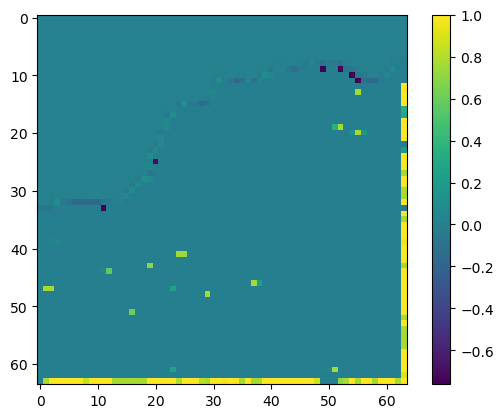

In [219]:
plt.imshow(output[7][17])
plt.colorbar()

In [220]:
res[2].shape

torch.Size([8, 360, 2, 64, 64])

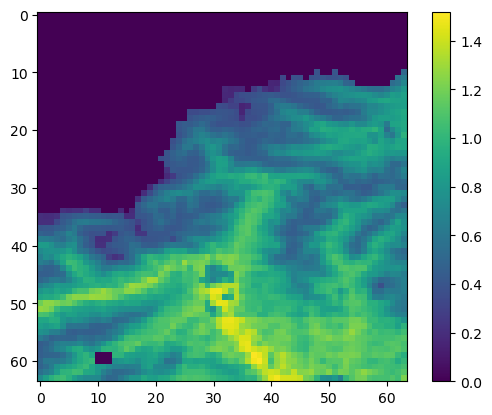

In [221]:
plt.imshow(res[2][7][-1][1])
plt.colorbar()